In [123]:
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize, sent_tokenize
import string
import re

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
corpus_raw = "Deep Learning has evolved from Artificial Neural Networks which has been there since the 1940s. Neural Networks are interconnected networks of processing units called artificial neurons, that loosely mimics axons in a biological brain. In a biological neuron, the Dendrites receive input signals from various neighboring neurons, typically greater than 1000. These modified signals are then passed on to the cell body or soma of the neuron where these signals are summed together and then passed on to the Axon of the neuron. If the received input signal is more than a specified threshold, the axon will release a signal which again will pass on to neighboring dendrites of other neurons. Figure 2-1 depicts the structure of a biological neuron for reference.The artificial neuron units are inspired from the biological neurons with some modifications as per convenience. Much like the dendrites the input connections to the neuron carry the attenuated or amplified input signals from other neighboring neurons. The signals are passed onto the neuron where the input signals are summed up and then a decision is taken what to output based on the total input received. For instance, for a binary threshold neuron output value of 1 is provided when the total input exceeds a pre-defined threshold, otherwise the output stays at 0. Several other types of neurons are used in artificial neural network and their implementation only differs with respect to the activation function on the total input to produce the neuron output. In Figure 2-2 the different biological equivalents are tagged in the artificial neuron for easy analogy and interpretation."

In [4]:
corpus_raw

'Deep Learning has evolved from Artificial Neural Networks which has been there since the 1940s. Neural Networks are interconnected networks of processing units called artificial neurons, that loosely mimics axons in a biological brain. In a biological neuron, the Dendrites receive input signals from various neighboring neurons, typically greater than 1000. These modified signals are then passed on to the cell body or soma of the neuron where these signals are summed together and then passed on to the Axon of the neuron. If the received input signal is more than a specified threshold, the axon will release a signal which again will pass on to neighboring dendrites of other neurons. Figure 2-1 depicts the structure of a biological neuron for reference.The artificial neuron units are inspired from the biological neurons with some modifications as per convenience. Much like the dendrites the input connections to the neuron carry the attenuated or amplified input signals from other neighbo

### Continuous Bag of Words (CBOW)

In [31]:
def normalize_text(text):
    pat = re.compile("[{}]".format(re.escape(string.punctuation)), flags=re.IGNORECASE)
    text = pat.sub(' ', text)
    return text.lower()

In [6]:
sentences

['Deep Learning has evolved from Artificial Neural Networks which has been there since the 1940s.',
 'Neural Networks are interconnected networks of processing units called artificial neurons, that loosely mimics axons in a biological brain.',
 'In a biological neuron, the Dendrites receive input signals from various neighboring neurons, typically greater than 1000.',
 'These modified signals are then passed on to the cell body or soma of the neuron where these signals are summed together and then passed on to the Axon of the neuron.',
 'If the received input signal is more than a specified threshold, the axon will release a signal which again will pass on to neighboring dendrites of other neurons.',
 'Figure 2-1 depicts the structure of a biological neuron for reference.The artificial neuron units are inspired from the biological neurons with some modifications as per convenience.',
 'Much like the dendrites the input connections to the neuron carry the attenuated or amplified input s

In [111]:
def create_neighbors_word(corpus, window=2):
    sentences = [normalize_text(sent).split() for sent in sent_tokenize(corpus)]
    inputs = []
    outputs = []
    num_neighbors = []
    for tokens in sentences:
        size = len(tokens)
        for i, word in enumerate(tokens):
            neighbors = ' '.join(tokens[max(0, i-window):i] + tokens[i+1: i+window+1])
            inputs.append(neighbors)
            num_neighbors.append(len(neighbors))
            outputs.append(word)
    return inputs, outputs, num_neighbors

def create_training_data(corpus, window=2):
    
    neighbors, words, neighbor_counts = create_neighbors_word(corpus, window)
    
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split())
    
    X = vectorizer.fit_transform(neighbors)   # shape(n_sample, n_words)
    c = np.array(neighbor_counts).reshape(-1, 1)
    X = X.toarray() / c
    Y = vectorizer.transform(words)     # shape(n_sample, n_words)
    return X, Y.toarray(), vectorizer

In [112]:
X_train, Y_train, vectorizer = create_training_data(corpus_raw, window=2)

In [113]:
X_train.shape, Y_train.shape

((267, 125), (267, 125))

In [114]:
vocab_size = X_train.shape[1]
n_samples = X_train.shape[0]

In [119]:
# bulid continuour bow
tf.reset_default_graph()

# parameters init
learning_rate = .001
embedded_dim = 128
epochs = 100
batch_size = 10
n_batches = int(np.ceil(n_samples / batch_size))

# init Variables
X = tf.placeholder(dtype=tf.float32, shape=[None, vocab_size])
Y = tf.placeholder(dtype=tf.float32, shape=[None, vocab_size])

W_in = tf.Variable(tf.random_normal(shape=(vocab_size, embedded_dim), stddev=.02), name='WI')
b_in = tf.Variable(tf.zeros(shape=[embedded_dim]), name='b_in')
W_out = tf.Variable(tf.random_normal(shape=(embedded_dim, vocab_size), stddev=.02), name='WO')
b_out = tf.Variable(tf.zeros(shape=[vocab_size]), name='b_out')

# operation
Z = tf.nn.bias_add(tf.matmul(X, W_in), b_in)
logits = tf.nn.bias_add(tf.matmul(Z, W_out), b_out)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

In [120]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(epochs):
        for j in range(n_batches):
            a, b = j*batch_size, (j+1)*batch_size
            X_batch, Y_batch = X_train[a:b, :], Y_train[a:b, :]

            sess.run(optimizer, feed_dict={X:X_batch, Y:Y_batch})
        print("Epoch {}: loss: {:.4f}".format(i+1, sess.run(cost, feed_dict={X:X_train, Y:Y_train})))
        
    W_embedd = sess.run(W_in)

Epoch 1: loss: 4.8089
Epoch 2: loss: 4.7474
Epoch 3: loss: 4.6224
Epoch 4: loss: 4.4815
Epoch 5: loss: 4.4024
Epoch 6: loss: 4.3835
Epoch 7: loss: 4.3773
Epoch 8: loss: 4.3723
Epoch 9: loss: 4.3676
Epoch 10: loss: 4.3631
Epoch 11: loss: 4.3586
Epoch 12: loss: 4.3541
Epoch 13: loss: 4.3494
Epoch 14: loss: 4.3447
Epoch 15: loss: 4.3397
Epoch 16: loss: 4.3346
Epoch 17: loss: 4.3293
Epoch 18: loss: 4.3237
Epoch 19: loss: 4.3178
Epoch 20: loss: 4.3117
Epoch 21: loss: 4.3053
Epoch 22: loss: 4.2985
Epoch 23: loss: 4.2914
Epoch 24: loss: 4.2839
Epoch 25: loss: 4.2760
Epoch 26: loss: 4.2677
Epoch 27: loss: 4.2589
Epoch 28: loss: 4.2497
Epoch 29: loss: 4.2401
Epoch 30: loss: 4.2300
Epoch 31: loss: 4.2194
Epoch 32: loss: 4.2084
Epoch 33: loss: 4.1969
Epoch 34: loss: 4.1850
Epoch 35: loss: 4.1727
Epoch 36: loss: 4.1601
Epoch 37: loss: 4.1470
Epoch 38: loss: 4.1336
Epoch 39: loss: 4.1199
Epoch 40: loss: 4.1058
Epoch 41: loss: 4.0912
Epoch 42: loss: 4.0762
Epoch 43: loss: 4.0607
Epoch 44: loss: 4.04

In [122]:
W_embedd.shape  # [n_words, n_embed]

(125, 128)

In [127]:
feature_names = vectorizer.get_feature_names()

In [153]:
W_2D = TSNE(n_components=2, perplexity=30).fit_transform(W_embedd)

[-3.0479562282562256,
 14.70280933380127,
 -9.5829496383666992,
 7.5810160636901855]

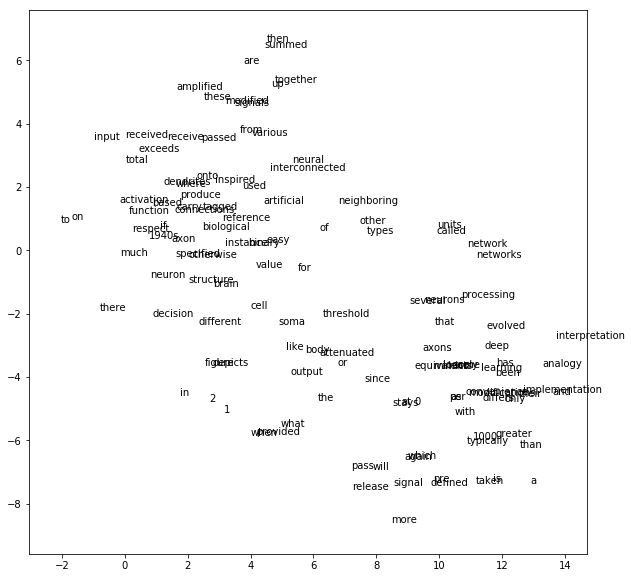

In [154]:
plt.figure(figsize=(10, 10))
for word, x, y in zip(feature_names, W_2D[:, 0], W_2D[:, 1]):
    plt.text(x, y, word)

plt.axis([W_2D[:, 0].min()-1, W_2D[:, 0].max()+1, W_2D[:, 1].min()-1, W_2D[:, 1].max()+1])

### Skip-Gram Model for Word Embedding

In [179]:
def create_training_skipgram(corpus, window=2):
    
    neighbors, words, _ = create_neighbors_word(corpus, window)
    X = []
    Y = []
    for nbs, word in zip(neighbors, words):
        for nb in nbs.split():
            X.append(word)
            Y.append(nb)
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split())
    X = vectorizer.fit_transform(X)
    Y = vectorizer.transform(Y)
    
    return X.toarray(), Y.toarray(), vectorizer

In [180]:
X_train, Y_train, vectorize = create_training_skipgram(corpus_raw, window=2)

In [181]:
Y_train.shape, X_train.shape

((1002, 125), (1002, 125))

In [184]:
feature_names = vectorize.get_feature_names()

In [201]:
# set parameters
embed_dim = 128
word_dim = X_train.shape[1]
learning_rate = .001
batch_size = 10
n_batch = int(np.ceil(len(X_train) / batch_size))
epochs = 200

tf.reset_default_graph()
# init variables
X = tf.placeholder(dtype=tf.float32, shape=[None, word_dim])
Y = tf.placeholder(dtype=tf.float32, shape=[None, word_dim])

WI = tf.Variable(tf.random_normal(shape=(word_dim, embed_dim), stddev=.02), name='WI')
bI = tf.Variable(tf.zeros(shape=[embed_dim]), name='bI')
WO = tf.Variable(tf.random_normal(shape=[embed_dim, word_dim], stddev=.02), name='WO')
bO = tf.Variable(tf.zeros(shape=[word_dim]), name='bO')

Z = tf.nn.bias_add(tf.matmul(X, WI), bI)
logits = tf.nn.bias_add(tf.matmul(Z, WO), bO)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

In [202]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(epochs):
        idx = np.random.permutation(range(X_train.shape[0]))
        for j in range(n_batch):
            a, b = j*n_batch, (j+1)*n_batch
            i_batch = idx[a:b]
            sess.run(optimizer, feed_dict={X:X_train[i_batch], Y:Y_train[i_batch]})
            
        if (i%20==0) or (i==epochs-1):
            loss = sess.run(cost, feed_dict={X:X_train, Y:Y_train})
            print('Epoch {}: loss: {:.4f}'.format(i+1, loss))
            
    W_embed = sess.run(WI)

Epoch 1: loss: 4.7958
Epoch 21: loss: 2.6166
Epoch 41: loss: 2.3108
Epoch 61: loss: 2.2615
Epoch 81: loss: 2.2455
Epoch 101: loss: 2.2386
Epoch 121: loss: 2.2350
Epoch 141: loss: 2.2326
Epoch 161: loss: 2.2323
Epoch 181: loss: 2.2319
Epoch 200: loss: 2.2279


In [205]:
W_2D = TSNE(n_components=2, perplexity=50).fit_transform(W_embed)

[-12.368120193481445,
 -0.7094806432723999,
 -5.1767640113830566,
 6.7749590873718262]

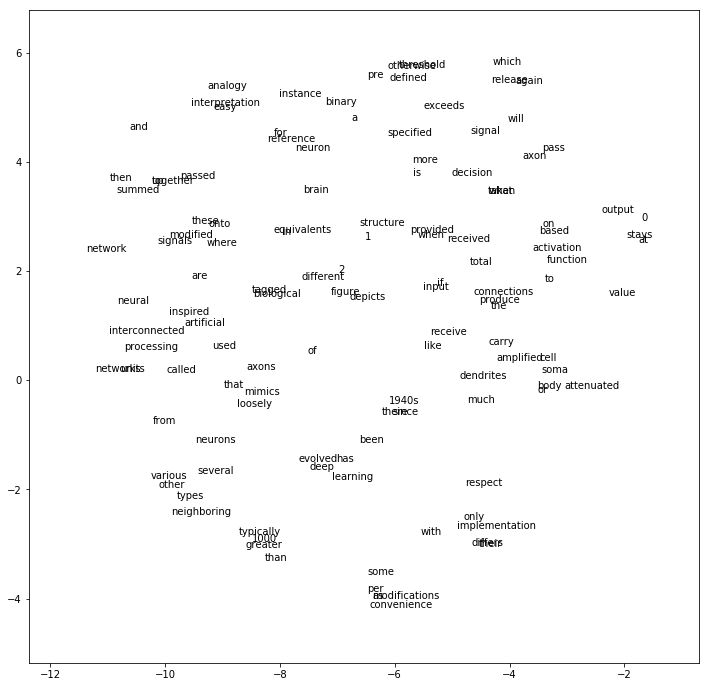

In [206]:
plt.figure(figsize=(12, 12))

for w, x, y in zip(feature_names, W_2D[:, 0], W_2D[:, 1]):
    plt.text(x, y, w)
    
plt.axis([W_2D[:, 0].min()-1, W_2D[:, 0].max()+1, W_2D[:, 1].min()-1, W_2D[:, 1].max()+1])